# Autoencoder

This deep neural networks made of two parts:
- An encoder: a network that learns to represent/compress the high-dimensional input data into a lower dimensional latent space
- A decoder: a network that learns to decompress a given representation/vector in the latent space to a high-dimensional representation

Often used to remove noise from images.

It is really easy to create an autoencoder using Keras Model Subclassing API as show in this [Tensorflow tutorial](https://www.tensorflow.org/tutorials/generative/autoencoder).

Let's build an autoencoder "from scratch" to have a better understanding!

## Hand Made Autoencoder

In [239]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, Flatten, Dense, Reshape, Conv2DTranspose, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Mean
from tensorflow.keras.datasets import mnist

import matplotlib.pyplot as plt

### Encoder

In [240]:
class Encoder():

    def __init__(self, input_dim, encoder_n_layers, encoder_conv_filters, encoder_conv_kernel_sizes, encoder_conv_strides, latent_dim):
        self.input_dim = input_dim
        self.encoder_n_layers = encoder_n_layers
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_sizes = encoder_conv_kernel_sizes
        self.encoder_conv_strides = encoder_conv_strides
        self.latent_dim = latent_dim

        if len(self.encoder_conv_filters) == len(self.encoder_conv_kernel_sizes) == len(self.encoder_conv_strides) == self.encoder_n_layers:
            pass
        else:
            print("ERROR")
            return

        self.input = Input(shape=self.input_dim, name="input")

        x = self.input

        for i in range(self.encoder_n_layers):
            conv_layer = Conv2D(filters=self.encoder_conv_filters[i],
                                kernel_size=self.encoder_conv_kernel_sizes[i],
                                strides=self.encoder_conv_strides[i],
                                padding="same",
                                name="encoder_conv_" + str(i))
            x = conv_layer(x)
            x = LeakyReLU()(x)

        self.shape_before_flattening = tf.keras.backend.int_shape(x)[1:] # See decoder

        x = Flatten()(x)

        self.output = Dense(self.latent_dim, name="output")(x)

        self.model = Model(self.input, self.output)


In [241]:
encoder = Encoder(input_dim=(28,28,1),
                          encoder_n_layers=4,
                          encoder_conv_filters=[32,64,64,64],
                          encoder_conv_kernel_sizes=[3,3,3,3],
                          encoder_conv_strides=[1,2,2,1],
                          latent_dim=2)

### Decoder

In [242]:
class Decoder():

    def __init__(self, latent_dim, shape_before_flattening, decoder_n_layers, decoder_conv_t_filters, decoder_conv_t_kernel_sizes, decoder_conv_t_strides, output_dim):
        self.output_dim = output_dim
        self.shape_before_flattening = shape_before_flattening
        self.decoder_n_layers = decoder_n_layers
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_sizes = decoder_conv_t_kernel_sizes
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.latent_dim = latent_dim

        if len(self.decoder_conv_t_filters) == len(self.decoder_conv_t_kernel_sizes) == len(self.decoder_conv_t_strides) == self.decoder_n_layers:
            pass
        else:
            print("ERROR")
            return

        self.input = Input(shape=(self.latent_dim,), name="input")

        x = Dense(np.prod(shape_before_flattening))(self.input) # Connect the input to a dense layer

        x = Reshape(self.shape_before_flattening)(x) # Reshape latent space vector for convolutional transpose layers

        for i in range(self.decoder_n_layers):
            conv_t_layer = Conv2DTranspose(filters=self.decoder_conv_t_filters[i],
                                           kernel_size=self.decoder_conv_t_kernel_sizes[i],
                                           strides=self.decoder_conv_t_strides[i],
                                           padding="same",
                                           name="decoder_conv_t_" + str(i))
            x = conv_t_layer(x)

            if i < self.decoder_n_layers - 1:
                x = LeakyReLU()(x)
            else:
                x = Activation("sigmoid")(x)

        self.output = x

        self.model = Model(self.input, self.output)

    def predict(self, x):
        return self.model.predict(x)
        

### Autoencoder

In [243]:
class Autoencoder():

    def __init__(self, input_dim,
                 encoder_n_layers, encoder_conv_filters, encoder_conv_kernel_sizes, encoder_conv_strides,
                 latent_dim,
                 decoder_n_layers, decoder_conv_t_filters, decoder_conv_t_kernel_sizes, decoder_conv_t_strides,
                 output_dim,
                 learning_rate):
        self.input_dim = input_dim
        self.encoder_n_layers = encoder_n_layers
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_sizes = encoder_conv_kernel_sizes
        self.encoder_conv_strides = encoder_conv_strides
        self.latent_dim = latent_dim
        self.decoder_n_layers = decoder_n_layers
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_sizes = decoder_conv_t_kernel_sizes
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.output_dim = output_dim

        self.learning_rate = learning_rate

        # Create encoder
        self.encoder = Encoder(self.input_dim,
                               self.encoder_n_layers, self.encoder_conv_filters, self.encoder_conv_kernel_sizes, self.encoder_conv_strides,
                               self.latent_dim)
        
        # Create decoder
        self.decoder = Decoder(self.latent_dim, self.encoder.shape_before_flattening,
                               self.decoder_n_layers, self.decoder_conv_t_filters, self.decoder_conv_t_kernel_sizes, self.decoder_conv_t_strides,
                               self.output_dim)
        
        # Create model
        self.model_input = self.encoder.input
        self.model_output = self.decoder.model(self.encoder.output)

        self.model = Model(self.model_input, self.model_output)

        # Compile model
        self.optimizer = Adam(learning_rate=self.learning_rate)
        
        self.model.compile(optimizer=self.optimizer, loss=MeanSquaredError())

    def summary(self):
        self.model.summary()

    def fit(self, x, y, batch_size, shuffle, epochs, callbacks):
        self.model.fit(x, y, batch_size, shuffle, epochs, callbacks)

    def predict(self, x):
        return self.model.predict(x)


In [244]:
autoencoder = Autoencoder(input_dim=(28,28,1),
                          encoder_n_layers=4,
                          encoder_conv_filters=[32,64,64,64],
                          encoder_conv_kernel_sizes=[3,3,3,3],
                          encoder_conv_strides=[1,2,2,1],
                          latent_dim=2,
                          decoder_n_layers=4,
                          decoder_conv_t_filters=[64,64,32,1],
                          decoder_conv_t_kernel_sizes=[3,3,3,3],
                          decoder_conv_t_strides=[1,2,2,1],
                          output_dim=(28,28,1),
                          learning_rate=10**-3)

In [245]:
autoencoder.summary()

Model: "model_103"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 28, 28, 32)        320       
                                                                 
 leaky_re_lu_279 (LeakyReLU  (None, 28, 28, 32)        0         
 )                                                               
                                                                 
 encoder_conv_1 (Conv2D)     (None, 14, 14, 64)        18496     
                                                                 
 leaky_re_lu_280 (LeakyReLU  (None, 14, 14, 64)        0         
 )                                                               
                                                                 
 encoder_conv_2 (Conv2D)     (None, 7, 7, 64)          36

### Training

In [246]:
# Load MNIST dataset
mnist_dataset = mnist.load_data()
(trainset, testset) = (mnist_dataset[0], mnist_dataset[1])
(X_train, y_train) = trainset
(X_test, y_test) = testset

# Preprocess data (convert to float and scale to between 0 and 1)
X_train = X_train.astype('float32')
X_train /= 255
X_test = X_test.astype('float32')
X_test /= 255

# Preprocess data (convert to uint8)
# y_train = y_train.astype('uint8')
# y_test = y_test.astype('uint8')

In [247]:
# Define callbacks
callbacks = []

In [248]:
autoencoder.fit(x=X_train,
                y=y_train,
                batch_size=20,
                shuffle=True,
                epochs=10,
                callbacks=callbacks)

2023-11-15 22:58:46.454336: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'gradient_tape/model_103/leaky_re_lu_282/LeakyRelu/LeakyReluGrad' exist for missing node 'model_103/encoder_conv_3/BiasAdd'.


### Predictions

#### Prediction from data set

In [249]:
predictions = autoencoder.predict(X_test)

313/313 [==============================] - 5s 14ms/step


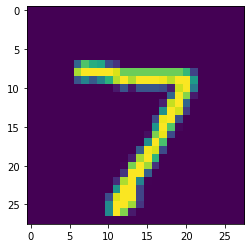

In [250]:
plt.imshow(X_test[0])

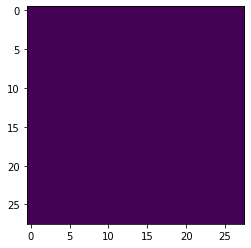

In [251]:
plt.imshow(predictions[0])

#### Random Prediction

In [252]:
latent_vector_1 = np.random.random(size=(1,2))
latent_vector_1

array([[0.67792575, 0.34272522]])

In [253]:
prediction_1 = autoencoder.decoder.predict(latent_vector_1)

1/1 [==============================] - 0s 219ms/step


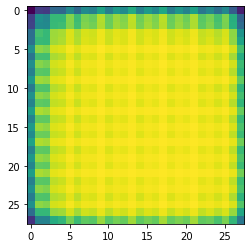

In [254]:
# prediction_1 = prediction_1.numpy()
prediction_1 = prediction_1[0]
plt.imshow(prediction_1)